In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import string 
import nltk

In [3]:
RANDOM_SEED = 42

In [4]:
train_df = pd.read_csv('dataset/raw_data.csv')

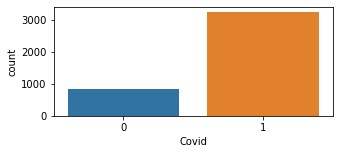

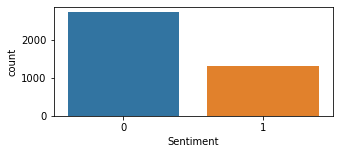

In [5]:
plt.figure(figsize=(5,2))
sns.countplot(train_df['Covid'])

plt.figure(figsize=(5,2))
sns.countplot(train_df['Sentiment'])

In [6]:
train_df.head(3)

,s,Date,Headline,Covid,Sentiment,Description,Image,Source
0,0,29-04-2020,"Coronavirus cases reach 2,438 in Rajasthan; 81...",1,0,Rajasthan on Wednesday reported 74 new coronav...,https://static.inshorts.com/inshorts/images/v1...,http://www.rajswasthya.nic.in/?utm_campaign=fu...
1,1,29-04-2020,"Coronavirus cases in Delhi surge to 3,439 afte...",1,0,The total number of coronavirus cases in Delhi...,https://static.inshorts.com/inshorts/images/v1...,https://twitter.com/shemin_joy/status/12555489...
2,2,30-04-2020,"Anguished, I'll always recall our interactions...",0,1,"Condoling the demise of actor Rishi Kapoor, PM...",https://static.inshorts.com/inshorts/images/v1...,https://twitter.com/narendramodi/status/125573...


In [7]:
train_df.drop(columns=['Date','Image','Source','s','Headline'],inplace=True) #removing non-significant columns

In [8]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

In [9]:
def create_dataset(df):
    lemma = WordNetLemmatizer()
    clean_news = []

    for sent in tqdm(df['Description']):
        sent = sent.lower()
        clean_sent = sent.translate(str.maketrans('','',string.punctuation))
        words = word_tokenize(sent)
        clean_words = [k for k in words if words not in stopwords.words('english')]
        lemma_words = [lemma.lemmatize(i) for i in clean_words]

        clean_news.append(lemma_words)

    return clean_news

    #cleans the news sentances and returns the list of significant words

In [10]:
train_news = create_dataset(train_df)

100%|██████████| 4072/4072 [01:03<00:00, 64.30it/s]


In [11]:
from keras.utils import to_categorical

In [51]:
y = train_df.drop('Description',axis=1)

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
x_train,x_val,y_train,y_val= train_test_split(train_news,y,test_size=0.2,random_state=RANDOM_SEED,stratify=y)

,Covid,Sentiment
737,1,0
2188,1,1
2709,1,1
1150,1,0
3907,0,1
...,...,...
2702,1,0
2712,1,1
3936,0,0
3090,1,0


In [56]:
y_train_covid = y_train.Covid
y_train_senti = y_train.Sentiment
y_train_covid = to_categorical(y_train_covid,2)
y_train_senti = to_categorical(y_train_senti,2)
num_classes_covid = y_train_covid.shape[1]
num_classes_senti = y_train_senti.shape[1]

y_val_covid = y_val.Covid
y_val_senti = y_val.Sentiment
y_val_covid = to_categorical(y_val_covid,2)
y_val_senti = to_categorical(y_val_senti,2)


In [57]:
len_max = 0
unique_words = set()

for sent in tqdm(x_train):
    unique_words.update(sent)
    
    if len(sent) > len_max:
        len_max = len(sent)

print()
print(len(unique_words))
print(len_max)


100%|██████████| 3257/3257 [00:00<00:00, 116640.75it/s]
12754
94



In [60]:
from keras.preprocessing import sequence 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping,ModelCheckpoint
from livelossplot import PlotLossesKeras

In [61]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)

x_train = sequence.pad_sequences(x_train,maxlen=len_max)
x_val = sequence.pad_sequences(x_val,maxlen=len_max)

In [62]:
from keras.models import Model
from keras.layers import Dense,LSTM,Dropout,Embedding,Input

In [63]:
def create_model():
    input_layer = Input(shape=(len_max,))
    x = Embedding(len(list(unique_words)),300,input_length=len_max)(input_layer)
    x = LSTM(64,recurrent_dropout=0.5,dropout=0.3,return_sequences=True)(x)
    x = LSTM(64,recurrent_dropout=0.5,dropout=0.3,return_sequences=False)(x)
    x = Dense(32,activation='relu')(x)
    x = Dropout(0.5)(x)
    bottle_neck = Dense(32,activation='relu')(x)
    out_covid = Dense(num_classes_covid,activation='sigmoid',name='out_covid')(bottle_neck)
    out_senti = Dense(num_classes_senti,activation='sigmoid',name='out_senti')(bottle_neck)

    model = Model(inputs=input_layer,outputs=[out_covid,out_senti])

    return model

In [64]:
model = create_model()
model.compile(optimizer='adam',
                loss={'out_covid':'binary_crossentropy','out_senti':'binary_crossentropy'},
                metrics={'out_covid':'accuracy','out_senti':'accuracy'})

In [65]:
callback = [EarlyStopping(patience=4,
                            monitor='val_accuracy'),
            PlotLossesKeras()]

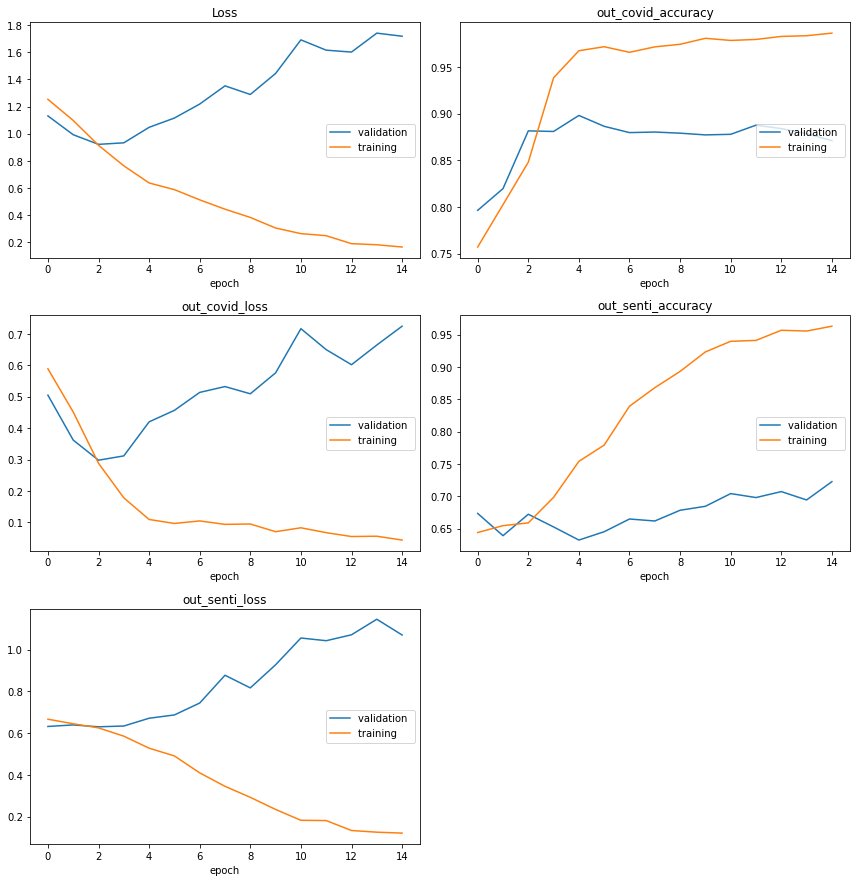

Loss
	validation       	 (min:    0.921, max:    1.741, cur:    1.719)
	training         	 (min:    0.164, max:    1.253, cur:    0.164)
out_covid_accuracy
	validation       	 (min:    0.796, max:    0.898, cur:    0.871)
	training         	 (min:    0.757, max:    0.986, cur:    0.986)
out_covid_loss
	validation       	 (min:    0.298, max:    0.724, cur:    0.724)
	training         	 (min:    0.044, max:    0.589, cur:    0.044)
out_senti_accuracy
	validation       	 (min:    0.633, max:    0.723, cur:    0.723)
	training         	 (min:    0.644, max:    0.963, cur:    0.963)
out_senti_loss
	validation       	 (min:    0.630, max:    1.146, cur:    1.070)
	training         	 (min:    0.121, max:    0.667, cur:    0.121)


In [66]:
h = model.fit(x_train,[y_train_covid,y_train_senti],
                validation_data=(x_val,[y_val_covid,y_val_senti]),
                epochs=15,
                batch_size=128,
                callbacks=callback)

In [78]:
# Model is over-fitted but this will do for now

In [67]:
from sklearn.metrics import accuracy_score,classification_report

In [73]:
model.save('Final_Model')

In [77]:
model_json = model.to_json()

with open('Model/final_model.json','w') as file:
    file.write(model_json)